In [1]:
import pandas as pd
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import tensorflow as tf

In [2]:
cols = [
    'ID',
    'diagnosis',
    'radius_m',
    'texture_m',
    'perimeter_m',
    'area_m',
    'smoothness_m',
    'compactness_m',
    'concavity_m',
    'concave_points_m',
    'symmetry_m',
    'fractal_dimension_m',
    'radius_se',
    'texture_se',
    'perimeter_se',
    'area_se',
    'smoothness_se',
    'compactness_se',
    'concavity_se',
    'concave_points_se',
    'symmetry_se',
    'fractal_dimension_se',
    'radius_w',
    'texture_w',
    'perimeter_w',
    'area_w',
    'smoothness_w',
    'compactness_w',
    'concavity_w',
    'concave_points_w',
    'symmetry_w',
    'fractal_dimension_w']

In [3]:
def serialize(obj):
    with open('pickle_files/'+namestr(obj)+'.pickle','wb') as f:
        pk.dump(obj,f,pk.HIGHEST_PROTOCOL)
        
def load(obj):
    with open('pickle_files/'+obj+'.pickle','rb') as f:
        return pk.load(f)

def namestr(obj):
    g = globals()
    return [name for name in g if g[name] is obj][0]

### Load dataset from .data file

In [4]:
with open('wdbc.data') as file:
    l = file.read().splitlines()
    l = [i.split(',') for i in l]
    data_set = pd.DataFrame(l, columns=cols)
    for i in data_set:
        data_set[i] = pd.to_numeric(data_set[i],errors='ignore')
    
    data_set = data_set.sample(frac=1).reset_index(drop=True)
    serialize(data_set)

### Load dataset from pickle file

In [5]:
data_set = load('data_set')

# M => 1, B => 0
data_set.replace('B', 0, inplace=True)
data_set.replace('M', 1, inplace=True)

X = data_set.iloc[:,2:]
y = data_set.iloc[:,1]

### Normalization

In [6]:
std = np.apply_along_axis(np.std,0,X)
mean = np.apply_along_axis(np.mean,0,X)

for i in range(len(X.columns)):
    X.iloc[:,i] -= mean[i]
    X.iloc[:,i] /= std[i]

In [7]:
data_set

,ID,diagnosis,radius_m,texture_m,perimeter_m,area_m,smoothness_m,compactness_m,concavity_m,concave_points_m,...,radius_w,texture_w,perimeter_w,area_w,smoothness_w,compactness_w,concavity_w,concave_points_w,symmetry_w,fractal_dimension_w
0,8610629,0,13.53,10.94,87.91,559.2,0.12910,0.10470,0.068770,0.065560,...,14.08,12.49,91.36,605.5,0.1451,0.13790,0.085390,0.07407,0.2710,0.07191
1,857810,0,13.05,19.31,82.61,527.2,0.08060,0.03789,0.000692,0.004167,...,14.23,22.25,90.24,624.1,0.1021,0.06191,0.001845,0.01111,0.2439,0.06289
2,868682,0,11.43,15.39,73.06,399.8,0.09639,0.06889,0.035030,0.028750,...,12.32,22.02,79.93,462.0,0.1190,0.16480,0.139900,0.08476,0.2676,0.06765
3,864018,0,11.34,21.26,72.48,396.5,0.08759,0.06575,0.051330,0.018990,...,13.01,29.15,83.99,518.1,0.1699,0.21960,0.312000,0.08278,0.2829,0.08832
4,881094802,1,17.42,25.56,114.50,948.0,0.10060,0.11460,0.168200,0.065970,...,18.07,28.07,120.40,1021.0,0.1243,0.17930,0.280300,0.10990,0.1603,0.06818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,909220,0,14.04,15.98,89.78,611.2,0.08458,0.05895,0.035340,0.029440,...,15.66,21.58,101.20,750.0,0.1195,0.12520,0.111700,0.07453,0.2725,0.07234
565,867387,0,15.71,13.93,102.00,761.7,0.09462,0.09462,0.071350,0.059330,...,17.50,19.25,114.30,922.8,0.1223,0.19490,0.170900,0.13740,0.2723,0.07071
566,897880,0,10.05,17.53,64.41,310.8,0.10070,0.07326,0.025110,0.017750,...,11.16,26.84,71.98,384.0,0.1402,0.14020,0.105500,0.06499,0.2894,0.07664
567,852781,1,18.61,20.25,122.10,1094.0,0.09440,0.10660,0.149000,0.077310,...,21.31,27.26,139.90,1403.0,0.1338,0.21170,0.344600,0.14900,0.2341,0.07421


### Confusion matrix functions

In [8]:
def tp(y, p):
    return sum(np.logical_and(y,p))

def fp(y, p):
    return sum(np.logical_and(np.logical_not(y),p))

def tn(y, p):
    return sum(np.logical_not(np.logical_or(y,p)))

def fn(y, p):
    return sum(np.logical_and(y,np.logical_not(p)))

### Metrics

In [9]:
def accuracy(y_true, y_prediction):
    return sum(np.logical_not(np.logical_xor(y_true, y_prediction)))/len(y_true)

def precision(y_true, y_prediction):
    true_positive  = tp(y_true, y_prediction)
    false_positive = fp(y_true, y_prediction)
    return true_positive / (true_positive + false_positive)

def recall(y_true, y_prediction):
    true_positive  = tp(y_true, y_prediction)
    false_negative = fn(y_true, y_prediction)
    return true_positive / (true_positive + false_negative)

def specifity(y_true, y_prediction):
    false_positive = fp(y_true, y_prediction)
    true_negative  = tn(y_true, y_prediction)
    return true_negative / (false_positive + true_negative)

def roc_auc(y_true, y_prediction):
    tpr = recall(y_true, y_prediction)
    fpr = 1 - specifity(y_true, y_prediction)
    return (tpr*fpr/2)+((tpr+1)/2)*(1-fpr)

### Training and Testing functions

In [10]:
def predict(model, x_train, y_train, x_test, y_test):
    model.fit(x_train,y_train)
    return model.predict(x_test)

def score(y_test, prediction):
    score = []
    score.append(accuracy(y_test, prediction))
    score.append(precision(y_test, prediction))
    score.append(recall(y_test, prediction))
    score.append(roc_auc(y_test, prediction))
    return np.array(score)

In [11]:
def cross_validation(X, y, n):
    options = []
    
    for i in range(n):
        X_folds = np.array_split(X, n)
        y_folds = np.array_split(y, n)
        
        x_test = X_folds.pop(i)
        y_test = y_folds.pop(i)

        options.append([pd.concat(X_folds),pd.concat(y_folds),x_test,y_test])
        
    return options

In [12]:
def result(model, X, y, n_fold):
    folds_option = cross_validation(X, y, n_fold)
    scores = []
    for i in folds_option:
        if len(scores):
            scores += score(i[3],predict(model, *i))
        else:
            scores = score(i[3],predict(model, *i))
    scores /= n_fold
    return {'accuracy' : scores[0], 
            'precision': scores[1], 
            'recall' : scores[2], 
            'auc' : scores[3]}

## Custom MLP

In [13]:
class MLP: 
    
    def __init__(self, 
                 num_perceptrons  = 128, 
                 activation       = tf.nn.relu, 
                 solver           = tf.train.AdamOptimizer, 
                 learning_rate    = .01, 
                 regularizer_rate = .1,
                 epochs           = 15, 
                 dropout_rate     = .6):
    
        self.num_perceptrons  = num_perceptrons
        self.activation       = activation
        self.solver           = solver
        self.learning_rate    = learning_rate
        self.regularizer_rate = regularizer_rate
        self.epochs           = epochs
        self.dropout_rate     = dropout_rate

    def fit(self, X, y):
        
        self.s = tf.get_default_session()
        if not self.s:
            self.s = tf.InteractiveSession()
            
        self.X_train = X
        self.y_train = y
        
        # initial data
        X      = np.array(X)     
        y      = np.array(y).reshape((-1,1))
        self.X_input = tf.placeholder('float', shape=(None, X.shape[1]), name='X')
        self.y_input = tf.placeholder('float', shape=(None, y.shape[1]), name='y')
        self.drop_rate = tf.placeholder('float')
        
        # initialize weights & bias
        weights_0 = tf.Variable(tf.random_normal([X.shape[1],self.num_perceptrons], 
                                                 stddev=(1/tf.sqrt(float(X.shape[1])))))
        bias_0    = tf.Variable(tf.random_normal([self.num_perceptrons]))

        weights_1 = tf.Variable(tf.random_normal([self.num_perceptrons,y.shape[1]], 
                                                 stddev=(1/tf.sqrt(float(self.num_perceptrons)))))
        bias_1    = tf.Variable(tf.random_normal([y.shape[1]]))
        
        # define layers
        hidden_output  = self.activation(tf.matmul(self.X_input, weights_0)+bias_0)
        dropped_output = tf.nn.dropout(hidden_output, rate=self.drop_rate)

        output         = tf.matmul(dropped_output,weights_1) + bias_1
        mean, var      = tf.nn.moments(output,0)
        self.predicted = tf.sigmoid((output - mean)/tf.sqrt(var))

        
        # optimization
        loss      = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.predicted,
                                                                              labels=self.y_input))\
        + self.regularizer_rate*(tf.reduce_sum(tf.square(bias_0)) + tf.reduce_sum(tf.square(bias_1)))
        
        optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(loss,var_list=[weights_0,
                                                                                       weights_1,
                                                                                       bias_0,
                                                                                       bias_1])
        # training
        self.s.run(tf.global_variables_initializer())
        for i in range(self.epochs):
            self.s.run(optimizer, {self.X_input:X, self.y_input:y, self.drop_rate:self.dropout_rate})
        

        
    def predict(self, x_test):
        prediction = self.s.run(self.predicted, {self.X_input:x_test, self.drop_rate:0})
        return np.where(prediction.reshape((-1,))>.5,1,0)

## Result

In [14]:
results = {}

results['logistic']    = result(LogisticRegression(max_iter=3000), X, y, 5)

results['svm']         = result(svm.SVC(), X, y, 5)

results['library_mlp'] = result(MLPClassifier(max_iter = 400, activation='relu'), X, y, 5)

results['custom_mlp']  = result(MLP(learning_rate=.025),X,y,5)

In [15]:
def plot(label='accuracy'):
    y_pos = np.arange(len(results))
    performance = [i[label] for i in results.values()]

    plt.bar(y_pos, performance)
    plt.xticks(y_pos, results.keys())
    plt.ylabel(label)
    plt.ylim(bottom=min(performance)-.05)

    plt.show()

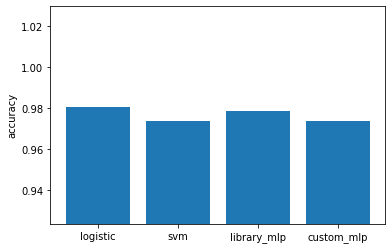

In [16]:
plot('accuracy')

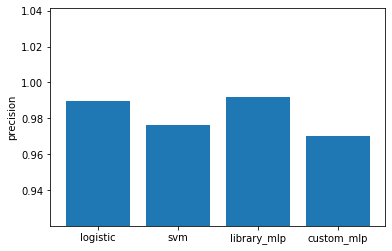

In [17]:
plot('precision')

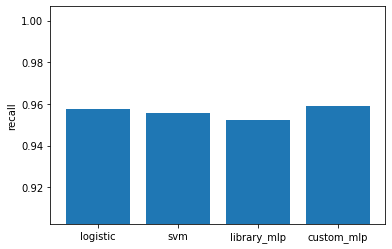

In [18]:
plot('recall')

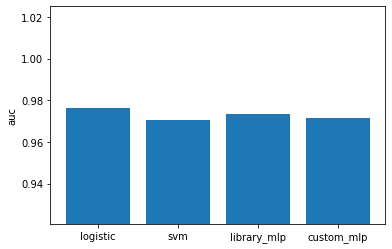

In [19]:
plot('auc')

In [20]:
results['custom_mlp']

{'accuracy': 0.9736376339077782,
 'precision': 0.9701026957637998,
 'recall': 0.9588216039279869,
 'auc': 0.9713747659279572}

In [21]:
results['library_mlp']

{'accuracy': 0.9789163173420276,
 'precision': 0.9916666666666668,
 'recall': 0.9523733023229104,
 'auc': 0.9731563481311521}

In [22]:
results['logistic']

{'accuracy': 0.9806707033069401,
 'precision': 0.989608636977058,
 'recall': 0.9577251126999167,
 'auc': 0.9761778716652737}

In [23]:
results['svm']

{'accuracy': 0.9736531594472908,
 'precision': 0.9761761426978819,
 'recall': 0.9554391707583196,
 'auc': 0.9706712643308387}